In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
def pl(img):
    plt.figure(dpi=400)
    plt.imshow(img)
def pls(img):
    plt.figure(dpi=150)
    plt.imshow(img)

In [3]:
images = []
f = open('photos.txt')
for line in f:
    if line != '\n':
        images.append(line[:-1])

In [71]:
image_name = 'photos/С624ТА799.jpg'

In [5]:
carplate_haar_cascade = cv2.CascadeClassifier('haarcascade_russian_plate_number.xml')

In [6]:
# https://github.com/AkhilmsAchu/No-Parking-Vehicle-Detection-NPVD
GAUSSIAN_SMOOTH_FILTER_SIZE = (5, 5)
ADAPTIVE_THRESH_BLOCK_SIZE = 11
ADAPTIVE_THRESH_WEIGHT = 9

def preprocess(imgOriginal):
    imgGrayscale = extractValue(imgOriginal)
    imgMaxContrastGrayscale = maximizeContrast(imgGrayscale)
    height, width = imgGrayscale.shape
    imgBlurred = np.zeros((height, width, 1), np.uint8)
    imgBlurred = cv2.GaussianBlur(imgMaxContrastGrayscale, GAUSSIAN_SMOOTH_FILTER_SIZE, 0)
    imgThresh = cv2.adaptiveThreshold(imgBlurred, 255.0, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                      cv2.THRESH_BINARY_INV, ADAPTIVE_THRESH_BLOCK_SIZE, ADAPTIVE_THRESH_WEIGHT)
    return imgGrayscale, imgThresh

def extractValue(imgOriginal):
    height, width, numChannels = imgOriginal.shape
    imgHSV = np.zeros((height, width, 3), np.uint8)
    imgHSV = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2HSV)
    imgHue, imgSaturation, imgValue = cv2.split(imgHSV)
    return imgValue

def maximizeContrast(imgGrayscale):
    height, width = imgGrayscale.shape
    imgTopHat = np.zeros((height, width, 1), np.uint8)
    imgBlackHat = np.zeros((height, width, 1), np.uint8)
    structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    imgTopHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_TOPHAT, structuringElement)
    imgBlackHat = cv2.morphologyEx(imgGrayscale, cv2.MORPH_BLACKHAT, structuringElement)
    imgGrayscalePlusTopHat = cv2.add(imgGrayscale, imgTopHat)
    imgGrayscalePlusTopHatMinusBlackHat = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat)
    return imgGrayscalePlusTopHatMinusBlackHat

In [7]:
def carplate_detect(image):
    carplate_overlay = image.copy() 
    carplate_rects = carplate_haar_cascade.detectMultiScale(carplate_overlay,scaleFactor=1.1, minNeighbors=3)
    x_max,y_max,w_max,h_max = carplate_rects[0]
    max_area = w_max * h_max
    for x,y,w,h in carplate_rects: 
        if max_area < w * h:
            max_area = w * h
            x_max,y_max,w_max,h_max = x, y, w, h  
            
        return carplate_overlay[max(0, y_max - 10): min(y_max + h_max + 10, 1280), max(0, x_max - 10): min(x_max + w_max + 10, 960)]
    
    
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")   
    rect[0] = pts[np.where(pts.sum(axis=(1,2)) == min(pts.sum(axis=(1, 2))))]
    rect[2] = pts[np.where(pts.sum(axis=(1,2)) == max(pts.sum(axis=(1,2))))] 
    diff = np.diff(pts, axis = 1)
    rect[3] = pts[np.where((pts[:,0,0] - pts[:,0,1]) == max((pts[:,0,0] - pts[:,0,1])))]
    rect[1] = pts[np.where((pts[:,0,0] - pts[:,0,1]) == min((pts[:,0,0] - pts[:,0,1])))]  
    return rect


def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = 900
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = 300
    
    dst = np.array([[0, 0], [0, maxHeight - 1],[maxWidth - 1, maxHeight - 1], [maxWidth - 1, 0]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

In [8]:
def predict_plate(image_name):
    img = cv2.imread(image_name)
    pls(img)
    
    detected_carplate_img = carplate_detect(img)
    pls(detected_carplate_img)
    
    size0, size1 = 600, 200
    detected_carplate_resized = cv2.resize(detected_carplate_img, (size0, size1), interpolation = cv2.INTER_AREA)
    preprocessed_detected_carplate = preprocess(detected_carplate_resized)[1] #cv2.cvtColor(detected_carplate_resized, cv2.COLOR_BGR2GRAY)# preprocess(detected_carplate_resized)[1]
    pls(preprocessed_detected_carplate)
    
    contours, _ = cv2.findContours(preprocessed_detected_carplate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    detected_carplate_copy = detected_carplate_resized.copy()
    contours = [cnt for cnt in contours if cv2.arcLength(cnt, True) > 200]
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 1000]
    contours = sorted(contours, key=cv2.contourArea)
    for contour in contours[-1:]:
        perimeter = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.001 * perimeter, True)
        rect = np.array(cv2.minAreaRect(contour),dtype='object')
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        cv2.drawContours(detected_carplate_copy,[box], 0, (0, 255, 255), 2)   
        
    pls(detected_carplate_copy)
    
    transformed_plate = four_point_transform(detected_carplate_resized, approx)
    pls(transformed_plate)
    return transformed_plate

UnboundLocalError: local variable 'approx' referenced before assignment

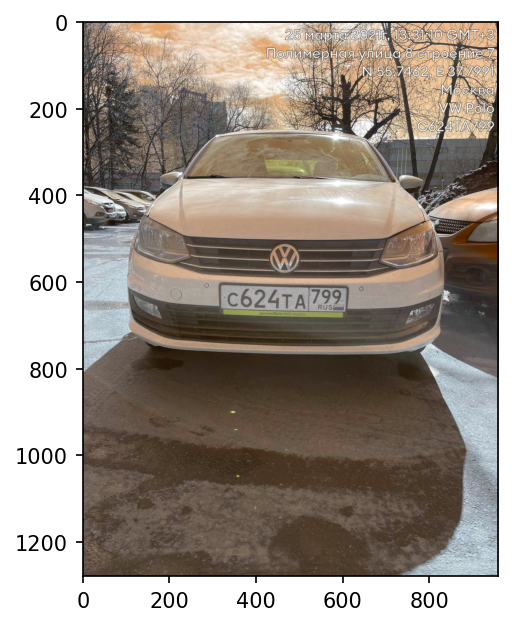

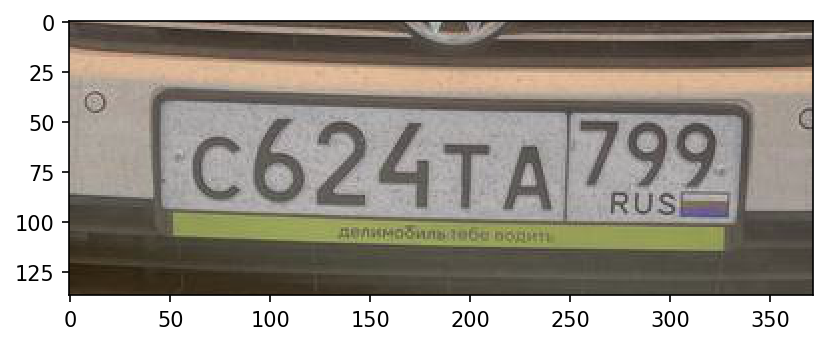

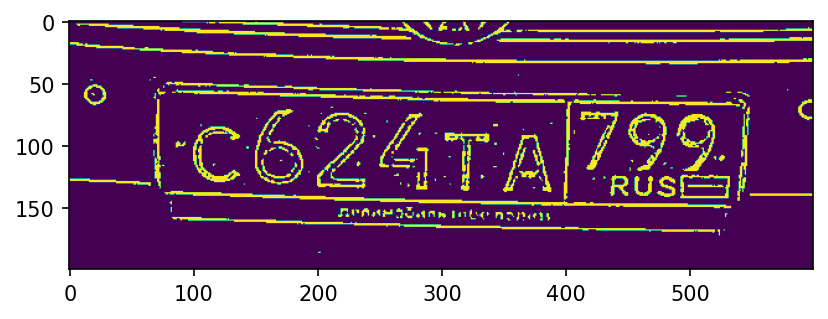

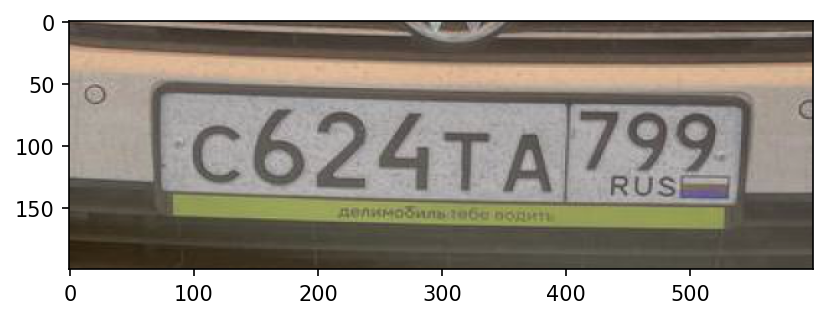

In [72]:
plate = predict_plate('photos/С624ТА799.jpg')

In [64]:
letters = []
for i in range(9):
    letters.append(cv2.resize(plate[:, 35 + i*100: 35 + (i+1)*100, :], (28, 28), interpolation = cv2.INTER_AREA))

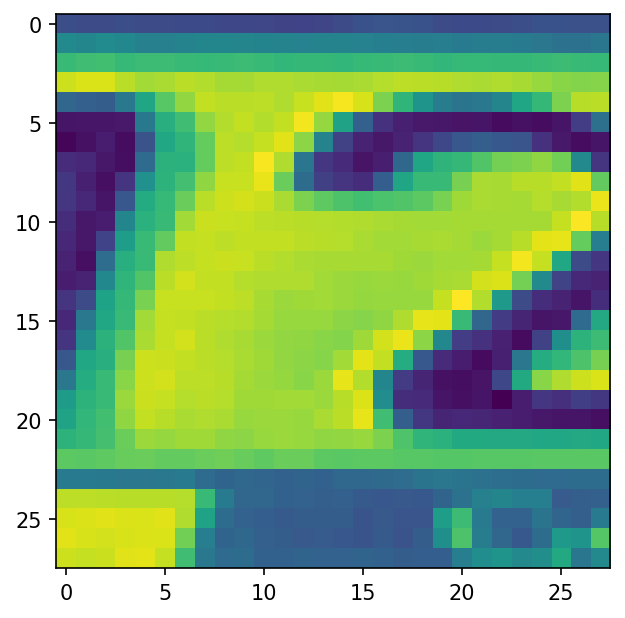

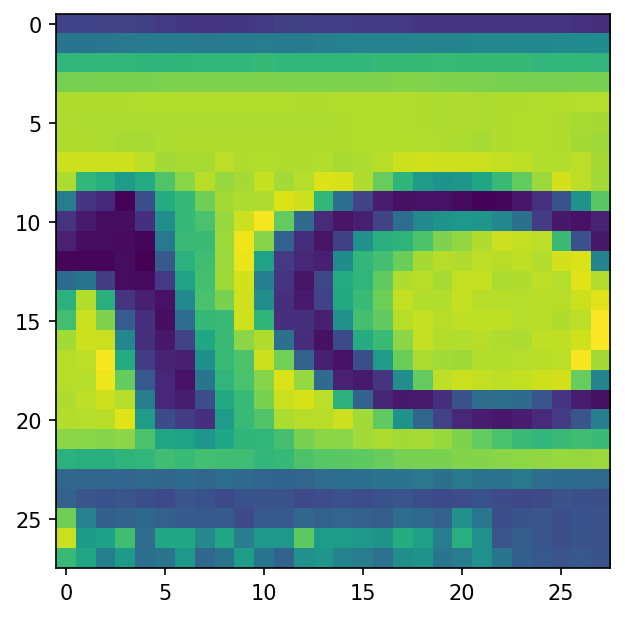

In [65]:
for i in range(len(letters)):
    letters[i] = cv2.cvtColor(letters[i], cv2.COLOR_BGR2GRAY)
pls(letters[3])
pls(letters[5])

In [66]:
import keras

In [67]:
model = keras.models.load_model('car_number_model.h5')
characters = ['0','1','2','3','4','5','6','7','8','9',
'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

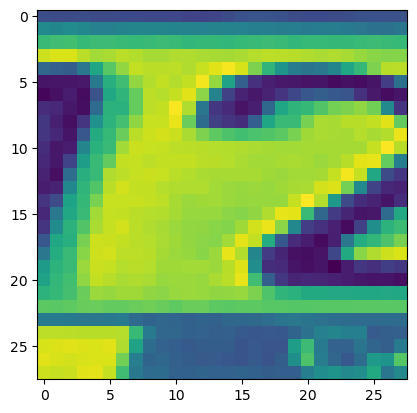

In [68]:
plt.imshow(letters[3])

In [69]:
num_str = ''
for letter in letters:
    num_str += characters[np.argmax(model.predict(letter.reshape((1, 28, 28))))]

1/1 [==============================] - 0s 12ms/step


In [70]:
num_str

'oeeeoeeea'

In [12]:
import pytesseract
print(pytesseract.image_to_string(plate, 
                                  config = f'--psm 8 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'))

IM272M0722

